# Vegetation Detection Filter (Classic Image Processing)

**Obiettivo**: Identificare e evidenziare la vegetazione (foreste) nelle immagini usando tecniche di image processing classico.

**Caratteristiche della vegetazione**:
- Dominanza del canale verde (G > R, G > B)
- Hue nello spazio HSV nel range verde (60-90° in OpenCV: 30-45)
- Indici di verdezza come Excess Green Index (ExG)

**Approccio**:
1. Excess Green Index (ExG = 2G - R - B)
2. Filtro HSV: range hue verde
3. Combinazione filtri con operazioni morfologiche
4. Visualizzazione: overlay verde + side-by-side
5. Valutazione su immagini green_area vs altre categorie

## 1. Imports

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
import random
from typing import Tuple, List

# Set random seed
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

print("Imports completed successfully")

Imports completed successfully


## 2. Configuration

In [5]:
# Paths
DATA_DIR = Path('../data')
CATEGORIES = ['cloudy', 'desert', 'green_area', 'water']
TARGET_SIZE = (64, 64)

# Filter parameters
EXG_THRESHOLD = 10  # Minimum Excess Green Index value

# HSV thresholds for green hue
# OpenCV Hue range: 0-179 (green is roughly 35-85)
HSV_THRESHOLDS = {
    'hue_min': 35,        # Lower bound for green hue
    'hue_max': 85,        # Upper bound for green hue
    'sat_min': 40,        # Minimum saturation (avoid grayish)
    'val_min': 40,        # Minimum value (avoid too dark)
}

# Morphological operations
MORPH_KERNEL_SIZE = 3

# Visualization
VEGETATION_COLOR = (0, 255, 0)  # Green in RGB
OVERLAY_ALPHA = 0.4

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"ExG threshold: {EXG_THRESHOLD}")
print(f"HSV thresholds: {HSV_THRESHOLDS}")

Data directory: /Users/aldojacopo/forme-idee/notebooks/../data
ExG threshold: 10
HSV thresholds: {'hue_min': 35, 'hue_max': 85, 'sat_min': 40, 'val_min': 40}


## 3. Utility Functions

In [6]:
def load_and_resize_image(img_path: Path, target_size: Tuple[int, int] = TARGET_SIZE) -> np.ndarray:
    """
    Load an image and resize it to target size.
    
    Args:
        img_path: Path to image file
        target_size: (width, height) tuple
    
    Returns:
        numpy array (H, W, 3) in RGB format
    """
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(target_size, Image.LANCZOS)
    return np.array(img_resized)


def load_sample_images(category: str, n_samples: int = 10) -> List[np.ndarray]:
    """
    Load random sample images from a category.
    """
    category_path = DATA_DIR / category
    image_files = list(category_path.glob('*.jpg'))
    sampled_files = random.sample(image_files, min(n_samples, len(image_files)))
    return [load_and_resize_image(f) for f in sampled_files]


print("Utility functions defined")

Utility functions defined


## 4. Vegetation Detection Filters

In [7]:
def calculate_excess_green_index(img_rgb: np.ndarray) -> np.ndarray:
    """
    Calculate Excess Green Index (ExG = 2G - R - B).
    Higher values indicate more green vegetation.
    
    Args:
        img_rgb: RGB image (H, W, 3)
    
    Returns:
        ExG array (H, W) with float values
    """
    img_float = img_rgb.astype(np.float32)
    r = img_float[:, :, 0]
    g = img_float[:, :, 1]
    b = img_float[:, :, 2]
    
    exg = 2 * g - r - b
    return exg


def detect_vegetation_exg(img_rgb: np.ndarray, 
                         threshold: float = EXG_THRESHOLD) -> np.ndarray:
    """
    Detect vegetation using Excess Green Index.
    
    Args:
        img_rgb: RGB image (H, W, 3)
        threshold: Minimum ExG value to consider as vegetation
    
    Returns:
        Binary mask (H, W) where 255 = vegetation, 0 = not vegetation
    """
    exg = calculate_excess_green_index(img_rgb)
    mask = (exg >= threshold).astype(np.uint8) * 255
    return mask


def detect_vegetation_hsv(img_rgb: np.ndarray,
                         hue_min: int = HSV_THRESHOLDS['hue_min'],
                         hue_max: int = HSV_THRESHOLDS['hue_max'],
                         sat_min: int = HSV_THRESHOLDS['sat_min'],
                         val_min: int = HSV_THRESHOLDS['val_min']) -> np.ndarray:
    """
    Detect vegetation using HSV color space.
    Green hue range in OpenCV: approximately 35-85 (out of 0-179).
    
    Args:
        img_rgb: RGB image (H, W, 3)
        hue_min: Minimum hue value
        hue_max: Maximum hue value
        sat_min: Minimum saturation (avoid grayish)
        val_min: Minimum value (avoid too dark)
    
    Returns:
        Binary mask (H, W) where 255 = vegetation, 0 = not vegetation
    """
    # Convert to HSV
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    
    # Define range for green color
    lower_green = np.array([hue_min, sat_min, val_min])
    upper_green = np.array([hue_max, 255, 255])
    
    # Create mask
    mask = cv2.inRange(img_hsv, lower_green, upper_green)
    
    return mask


def detect_vegetation_combined(img_rgb: np.ndarray,
                              use_morph: bool = True,
                              kernel_size: int = MORPH_KERNEL_SIZE) -> np.ndarray:
    """
    Combine ExG and HSV filters for robust vegetation detection.
    Apply morphological operations to clean up the mask.
    
    Args:
        img_rgb: RGB image (H, W, 3)
        use_morph: Whether to apply morphological operations
        kernel_size: Size of morphological kernel
    
    Returns:
        Binary mask (H, W) where 255 = vegetation, 0 = not vegetation
    """
    # Get masks from both methods
    mask_exg = detect_vegetation_exg(img_rgb)
    mask_hsv = detect_vegetation_hsv(img_rgb)
    
    # Combine with AND operation (pixel must be detected by both methods)
    # This is more conservative than OR and reduces false positives
    mask_combined = cv2.bitwise_and(mask_exg, mask_hsv)
    
    # Apply morphological operations to reduce noise
    if use_morph:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
        
        # Opening: removes small noise
        mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel)
        
        # Closing: fills small holes
        mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel)
    
    return mask_combined


print("Vegetation detection filters defined")

Vegetation detection filters defined


## 5. Visualization Functions

In [8]:
def apply_colored_overlay(img_rgb: np.ndarray, 
                         mask: np.ndarray,
                         color: Tuple[int, int, int] = VEGETATION_COLOR,
                         alpha: float = OVERLAY_ALPHA) -> np.ndarray:
    """
    Apply a colored semi-transparent overlay to the image based on the mask.
    
    Args:
        img_rgb: Original RGB image (H, W, 3)
        mask: Binary mask (H, W) where 255 = apply overlay
        color: RGB color tuple for overlay
        alpha: Transparency (0=transparent, 1=opaque)
    
    Returns:
        Image with overlay applied (H, W, 3)
    """
    # Create overlay image
    overlay = np.zeros_like(img_rgb)
    overlay[mask > 0] = color
    
    # Blend original image with overlay
    result = img_rgb.copy()
    mask_bool = mask > 0
    result[mask_bool] = (alpha * overlay[mask_bool] + 
                         (1 - alpha) * img_rgb[mask_bool]).astype(np.uint8)
    
    return result


def visualize_detection(img_rgb: np.ndarray,
                       mask: np.ndarray,
                       title: str = "Vegetation Detection") -> None:
    """
    Visualize original image, mask, and overlay side-by-side.
    
    Args:
        img_rgb: Original RGB image
        mask: Binary detection mask
        title: Plot title
    """
    overlay = apply_colored_overlay(img_rgb, mask)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Detection Mask', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay (Green = Vegetation)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def visualize_filter_comparison(img_rgb: np.ndarray) -> None:
    """
    Compare ExG, HSV, and combined filter results.
    """
    mask_exg = detect_vegetation_exg(img_rgb)
    mask_hsv = detect_vegetation_hsv(img_rgb)
    mask_combined = detect_vegetation_combined(img_rgb)
    
    # Also visualize the ExG index as heatmap
    exg_index = calculate_excess_green_index(img_rgb)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # ExG index heatmap
    im = axes[0, 1].imshow(exg_index, cmap='RdYlGn')
    axes[0, 1].set_title('ExG Index (2G-R-B)', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # ExG mask
    axes[0, 2].imshow(mask_exg, cmap='gray')
    axes[0, 2].set_title('ExG Filter Mask', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    # HSV mask
    axes[1, 0].imshow(mask_hsv, cmap='gray')
    axes[1, 0].set_title('HSV Filter (green hue)', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Combined mask
    axes[1, 1].imshow(mask_combined, cmap='gray')
    axes[1, 1].set_title('Combined (ExG AND HSV + Morph)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    # Overlay
    overlay = apply_colored_overlay(img_rgb, mask_combined)
    axes[1, 2].imshow(overlay)
    axes[1, 2].set_title('Final Overlay', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle('Vegetation Detection - Filter Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


print("Visualization functions defined")

Visualization functions defined


## 6. Test on Sample Images

### 6.1 Test on Green Area (Vegetation) Images

Loaded 5 green area images

Testing on green area image, shape: (64, 64, 3)


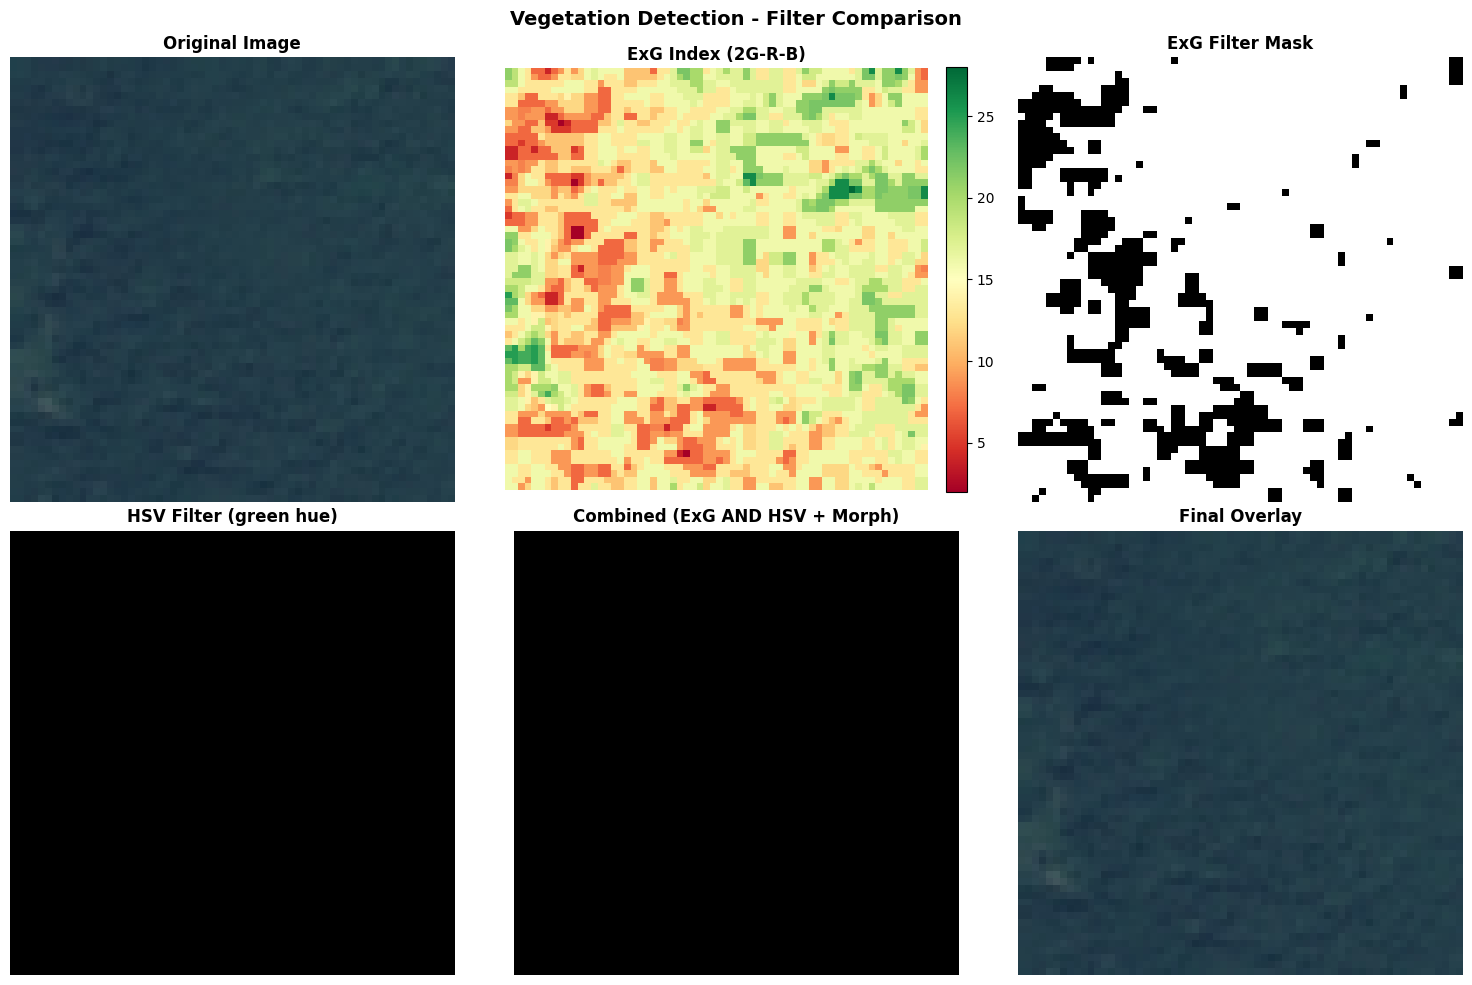

In [9]:
# Load green area samples
green_samples = load_sample_images('green_area', n_samples=5)
print(f"Loaded {len(green_samples)} green area images")

# Test filter on first vegetation image
test_img = green_samples[0]
print(f"\nTesting on green area image, shape: {test_img.shape}")

# Compare different filters
visualize_filter_comparison(test_img)

Testing vegetation detection on multiple green area images:


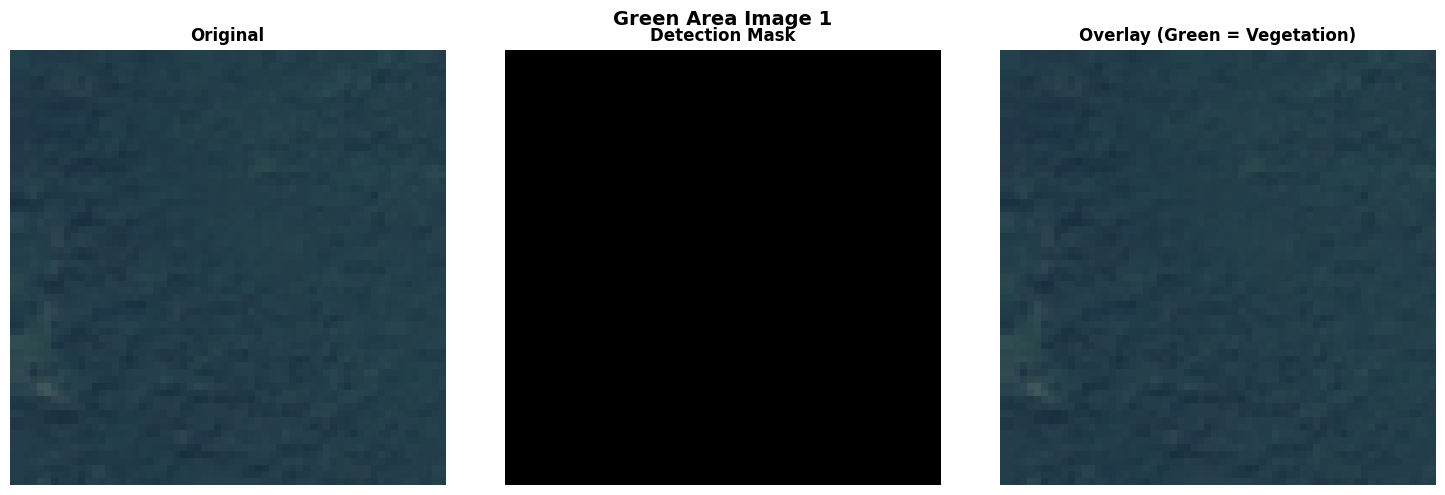

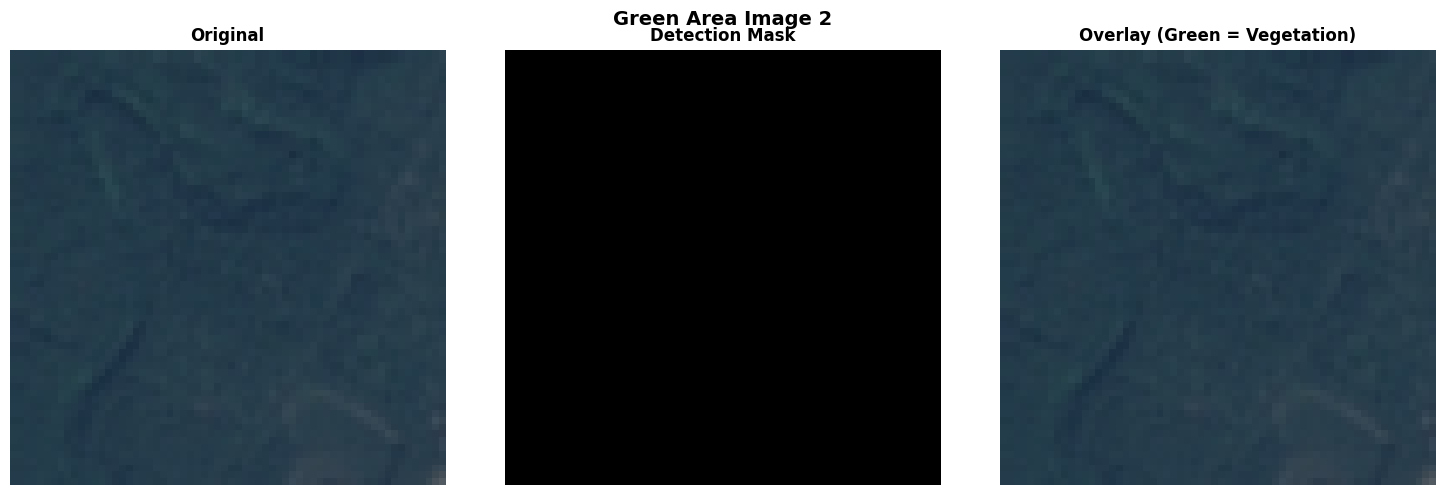

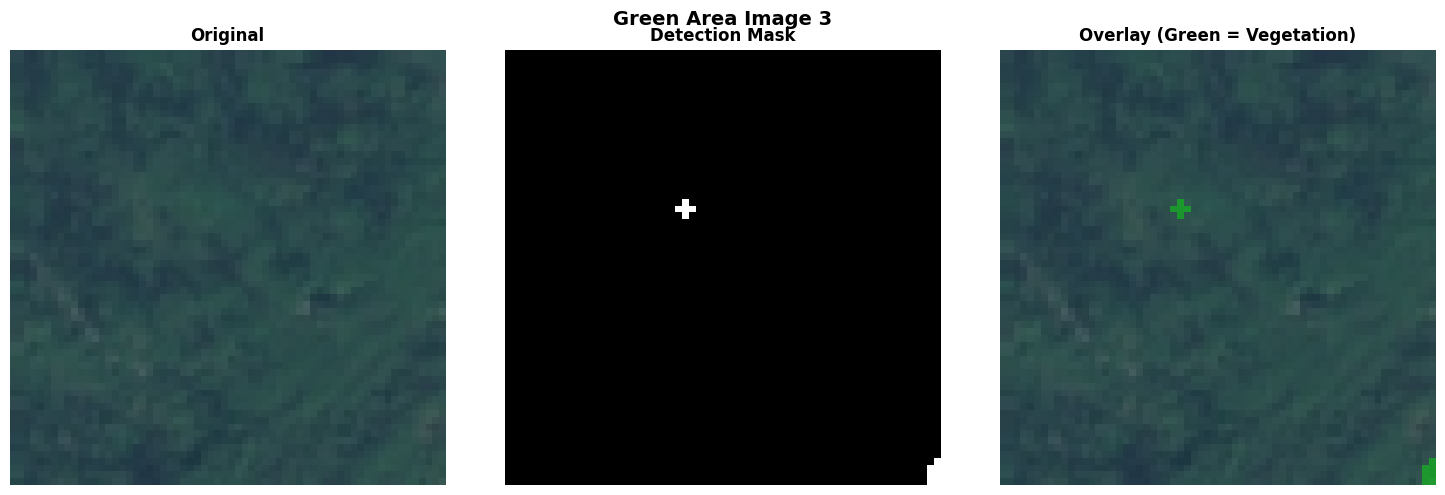

In [10]:
# Test on multiple vegetation images
print("Testing vegetation detection on multiple green area images:")
for i, img in enumerate(green_samples[:3]):
    mask = detect_vegetation_combined(img)
    visualize_detection(img, mask, title=f"Green Area Image {i+1}")

### 6.2 Test on Non-Vegetation Images (Control)

Testing vegetation detection on NON-vegetation images:
(Should detect minimal or no vegetation)

--- Cloudy ---


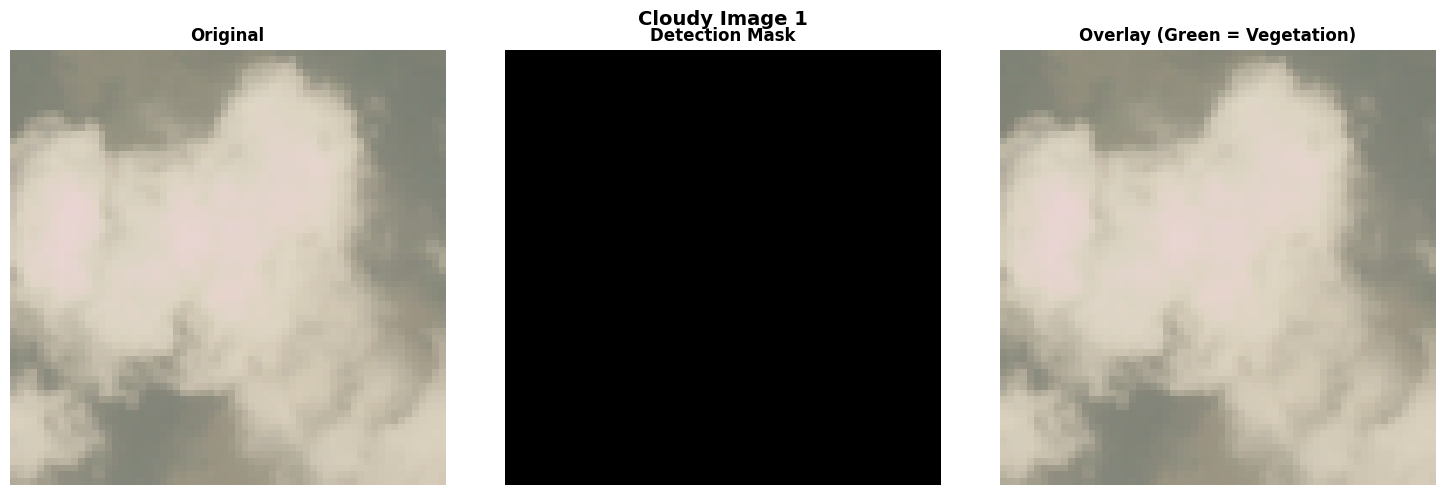

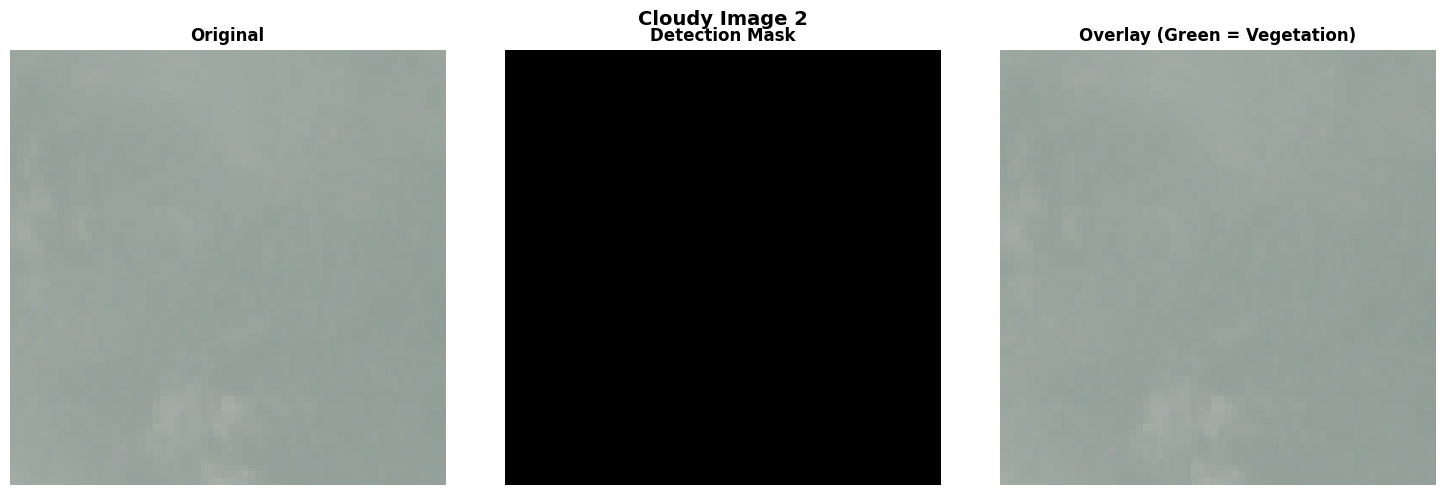

--- Desert ---


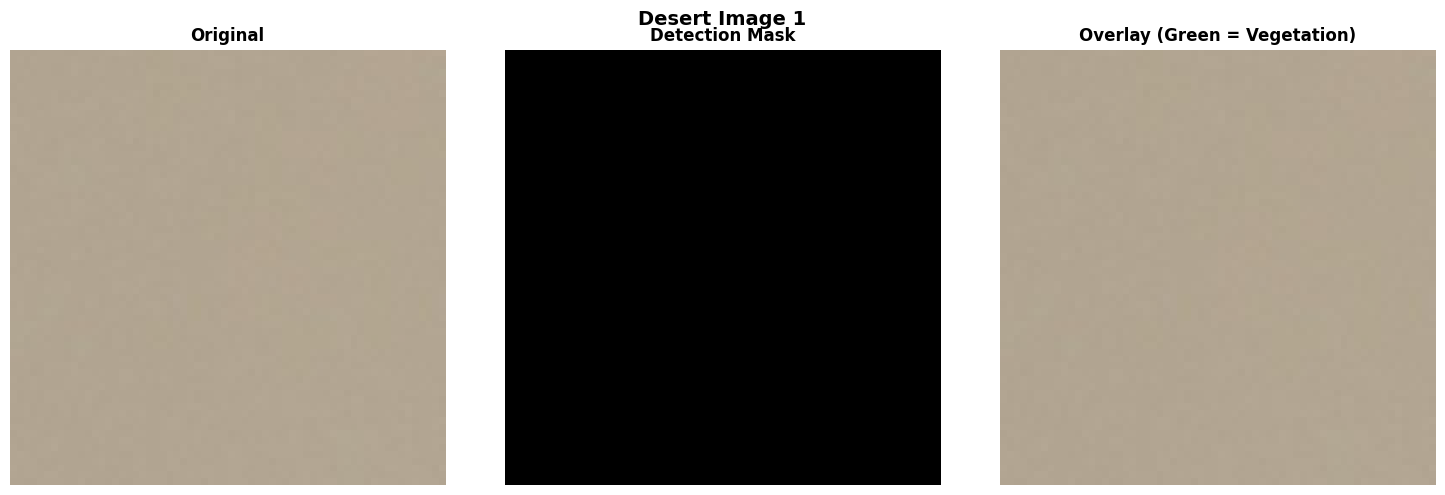

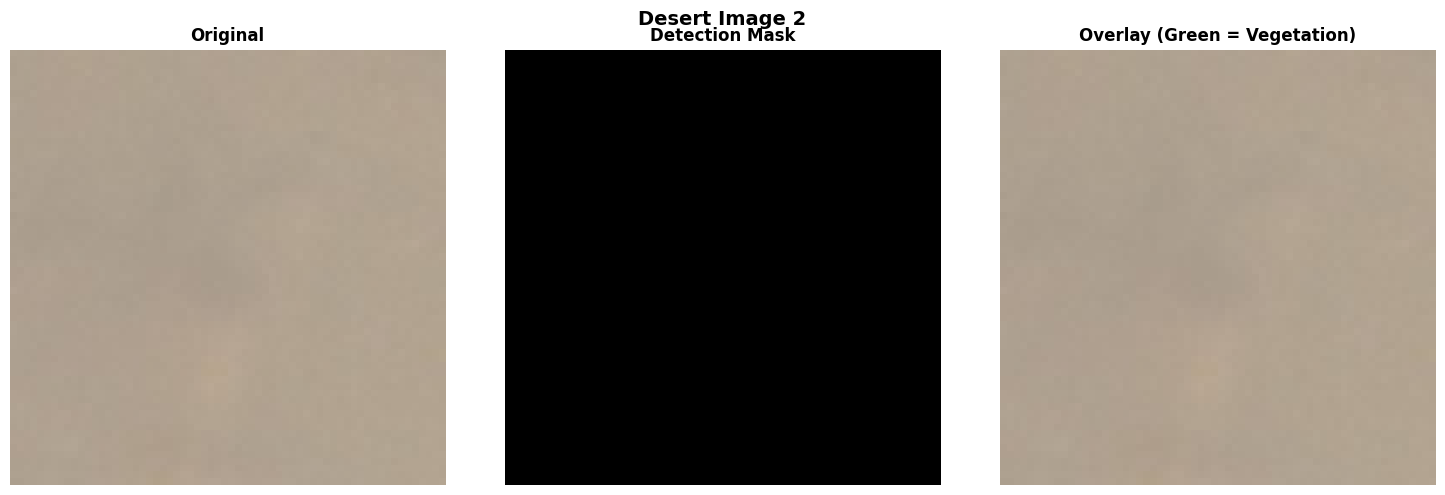

--- Water ---


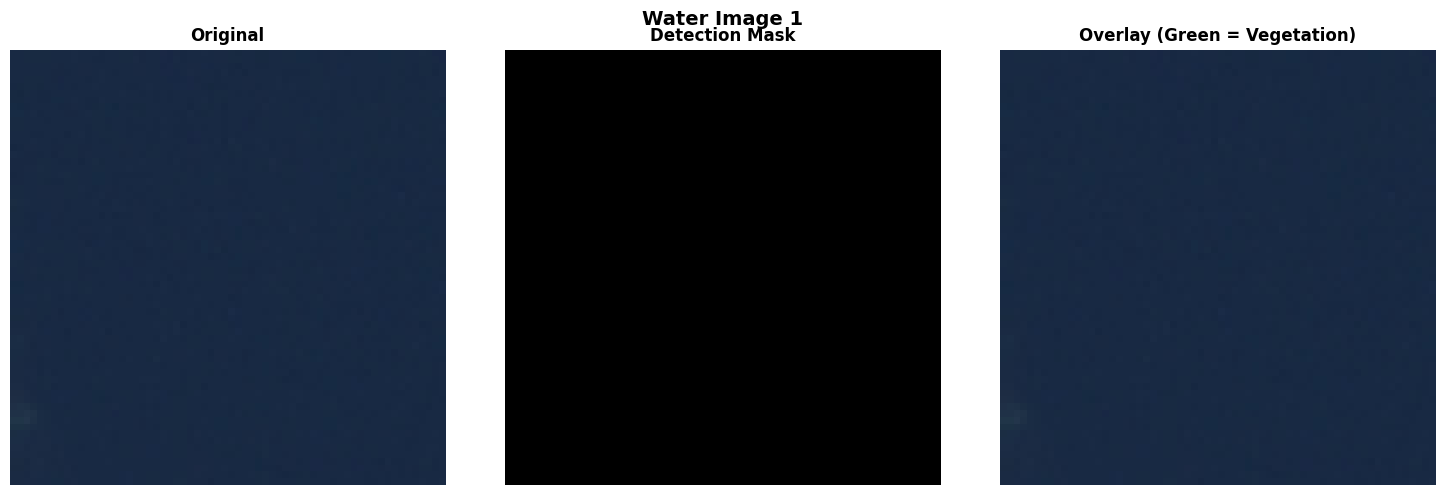

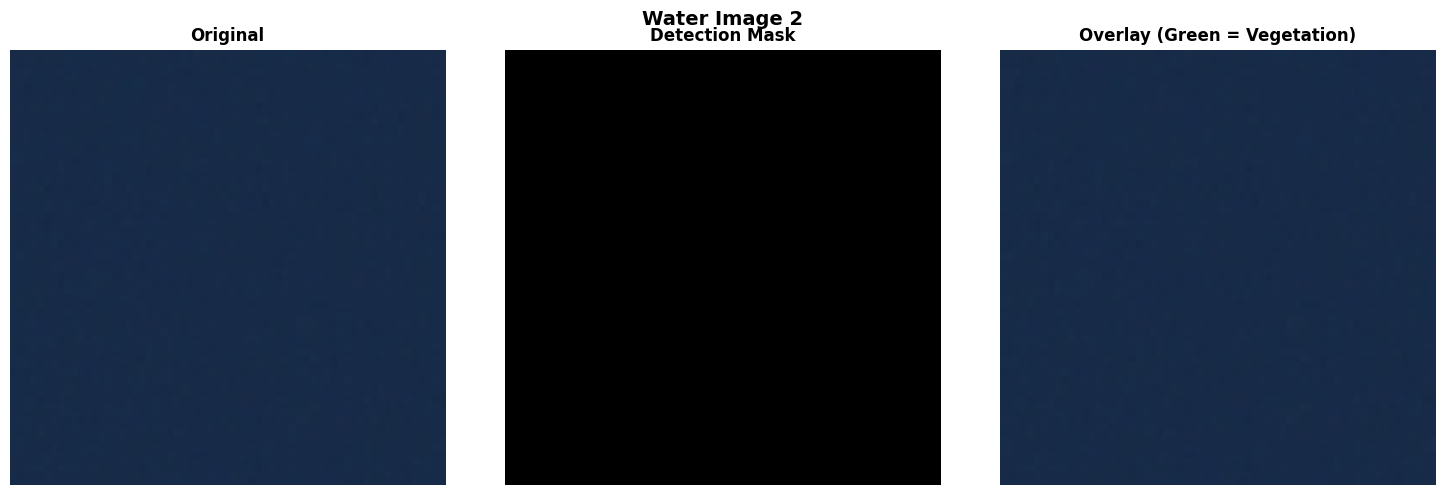

In [11]:
# Load samples from other categories
cloudy_samples = load_sample_images('cloudy', n_samples=2)
desert_samples = load_sample_images('desert', n_samples=2)
water_samples = load_sample_images('water', n_samples=2)

print("Testing vegetation detection on NON-vegetation images:")
print("(Should detect minimal or no vegetation)\n")

# Test cloudy
print("--- Cloudy ---")
for i, img in enumerate(cloudy_samples):
    mask = detect_vegetation_combined(img)
    visualize_detection(img, mask, title=f"Cloudy Image {i+1}")

# Test desert
print("--- Desert ---")
for i, img in enumerate(desert_samples):
    mask = detect_vegetation_combined(img)
    visualize_detection(img, mask, title=f"Desert Image {i+1}")

# Test water
print("--- Water ---")
for i, img in enumerate(water_samples):
    mask = detect_vegetation_combined(img)
    visualize_detection(img, mask, title=f"Water Image {i+1}")

## 7. Quantitative Evaluation

In [12]:
def calculate_vegetation_coverage(mask: np.ndarray) -> float:
    """
    Calculate percentage of image covered by vegetation.
    
    Args:
        mask: Binary mask (H, W)
    
    Returns:
        Percentage (0-100)
    """
    total_pixels = mask.size
    vegetation_pixels = np.sum(mask > 0)
    return (vegetation_pixels / total_pixels) * 100


def evaluate_filter_on_category(category: str, n_samples: int = 20) -> dict:
    """
    Evaluate vegetation filter on a category and compute statistics.
    
    Returns:
        dict with mean, std, min, max vegetation coverage percentage
    """
    images = load_sample_images(category, n_samples)
    coverages = []
    
    for img in images:
        mask = detect_vegetation_combined(img)
        coverage = calculate_vegetation_coverage(mask)
        coverages.append(coverage)
    
    return {
        'mean': np.mean(coverages),
        'std': np.std(coverages),
        'min': np.min(coverages),
        'max': np.max(coverages)
    }


print("Evaluating vegetation detection across all categories...\n")

results = {}
for category in CATEGORIES:
    print(f"Processing {category}...")
    results[category] = evaluate_filter_on_category(category, n_samples=20)

print("\n" + "="*70)
print("VEGETATION COVERAGE STATISTICS (%)")
print("="*70)
for category in CATEGORIES:
    stats = results[category]
    print(f"\n{category.replace('_', ' ').title()}:")
    print(f"  Mean:   {stats['mean']:.2f}%")
    print(f"  Std:    {stats['std']:.2f}%")
    print(f"  Range:  {stats['min']:.2f}% - {stats['max']:.2f}%")

print("\n" + "="*70)
print("Expected: Green_area images should have HIGH coverage (>50%)")
print("          Other categories should have LOW coverage (<20%)")
print("="*70)

Evaluating vegetation detection across all categories...

Processing cloudy...
Processing desert...
Processing green_area...
Processing water...

VEGETATION COVERAGE STATISTICS (%)

Cloudy:
  Mean:   2.33%
  Std:    8.25%
  Range:  0.00% - 37.28%

Desert:
  Mean:   0.00%
  Std:    0.00%
  Range:  0.00% - 0.00%

Green Area:
  Mean:   5.79%
  Std:    17.38%
  Range:  0.00% - 58.13%

Water:
  Mean:   3.42%
  Std:    14.89%
  Range:  0.00% - 68.33%

Expected: Green_area images should have HIGH coverage (>50%)
          Other categories should have LOW coverage (<20%)


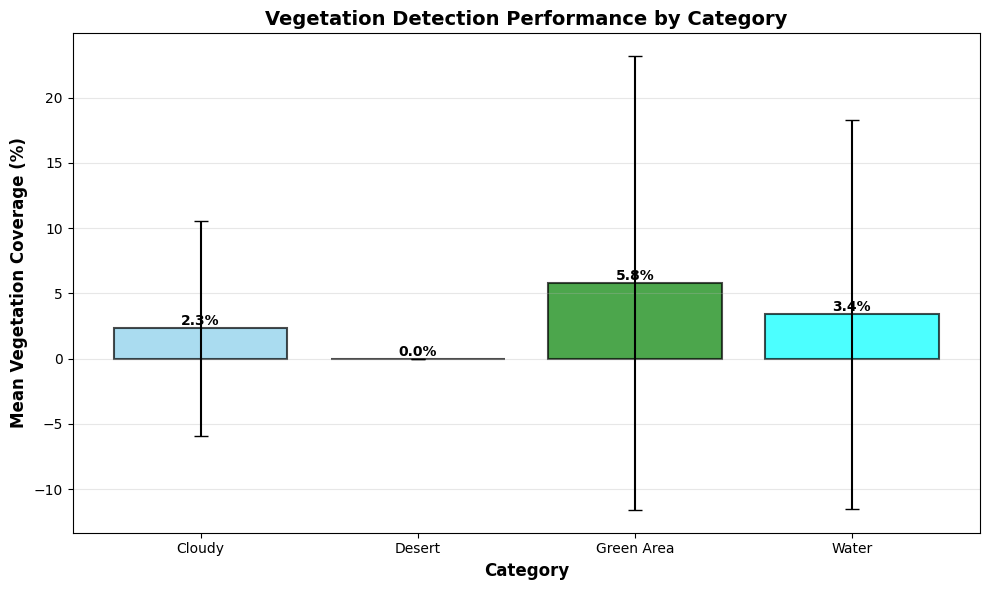

In [13]:
# Visualize results as bar chart
categories_labels = [cat.replace('_', ' ').title() for cat in CATEGORIES]
means = [results[cat]['mean'] for cat in CATEGORIES]
stds = [results[cat]['std'] for cat in CATEGORIES]

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(categories_labels))
bars = ax.bar(x, means, yerr=stds, capsize=5, alpha=0.7, 
              color=['skyblue', 'orange', 'green', 'cyan'],
              edgecolor='black', linewidth=1.5)

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Vegetation Coverage (%)', fontsize=12, fontweight='bold')
ax.set_title('Vegetation Detection Performance by Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories_labels)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Parameter Tuning (Optional)

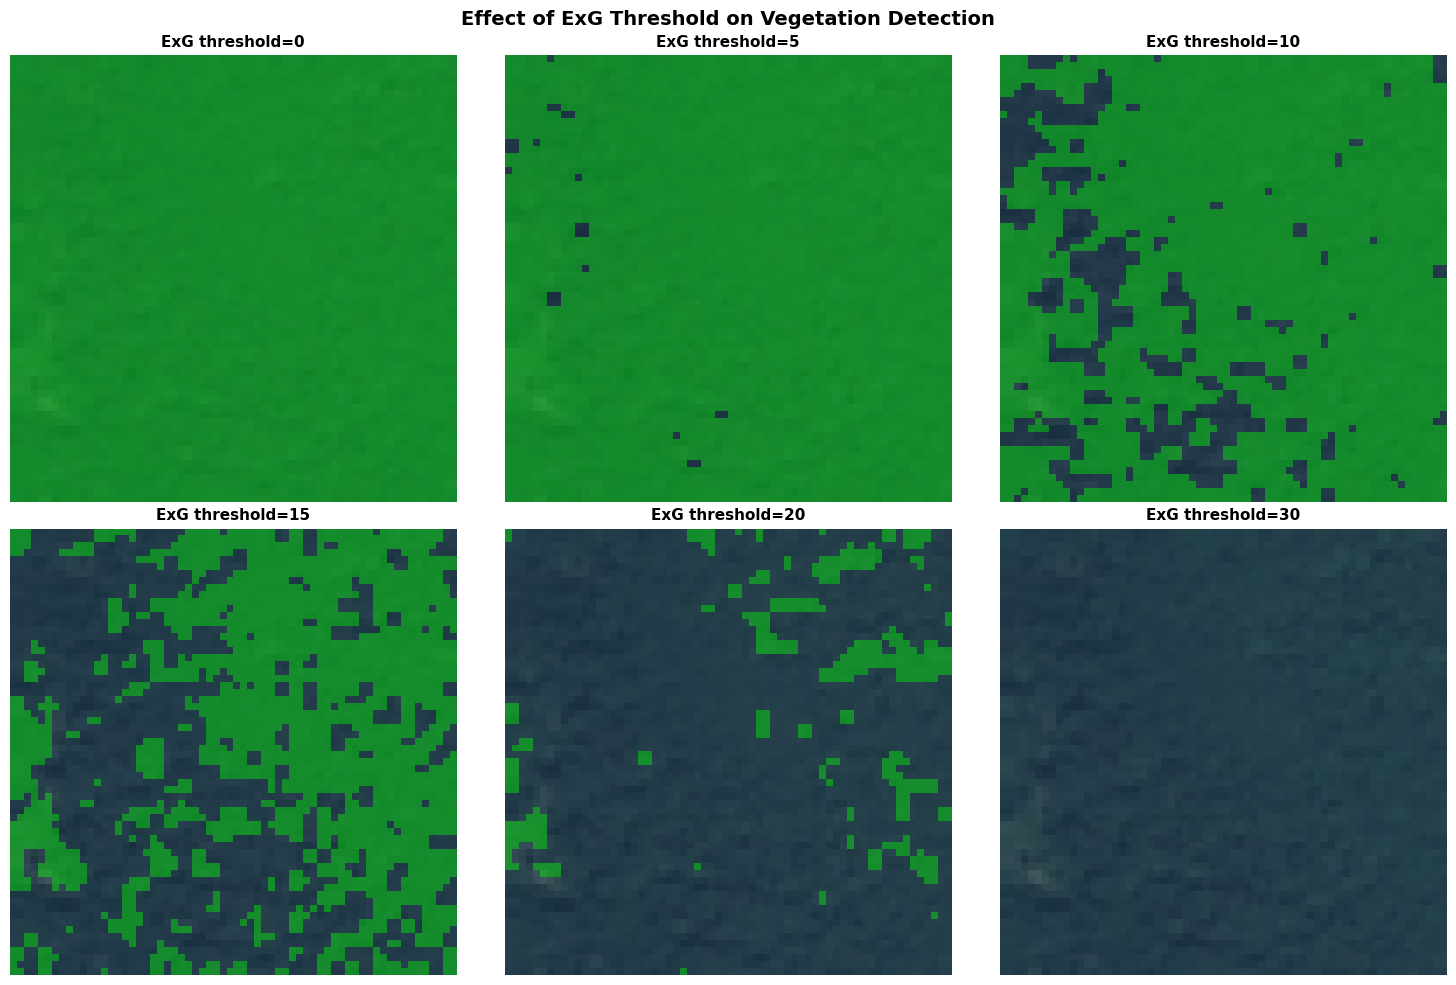

In [14]:
# Experiment with different ExG thresholds
test_img = green_samples[0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

exg_thresholds = [0, 5, 10, 15, 20, 30]

for idx, threshold in enumerate(exg_thresholds):
    row = idx // 3
    col = idx % 3
    
    mask = detect_vegetation_exg(test_img, threshold=threshold)
    overlay = apply_colored_overlay(test_img, mask)
    
    axes[row, col].imshow(overlay)
    axes[row, col].set_title(f'ExG threshold={threshold}', fontsize=11, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Effect of ExG Threshold on Vegetation Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

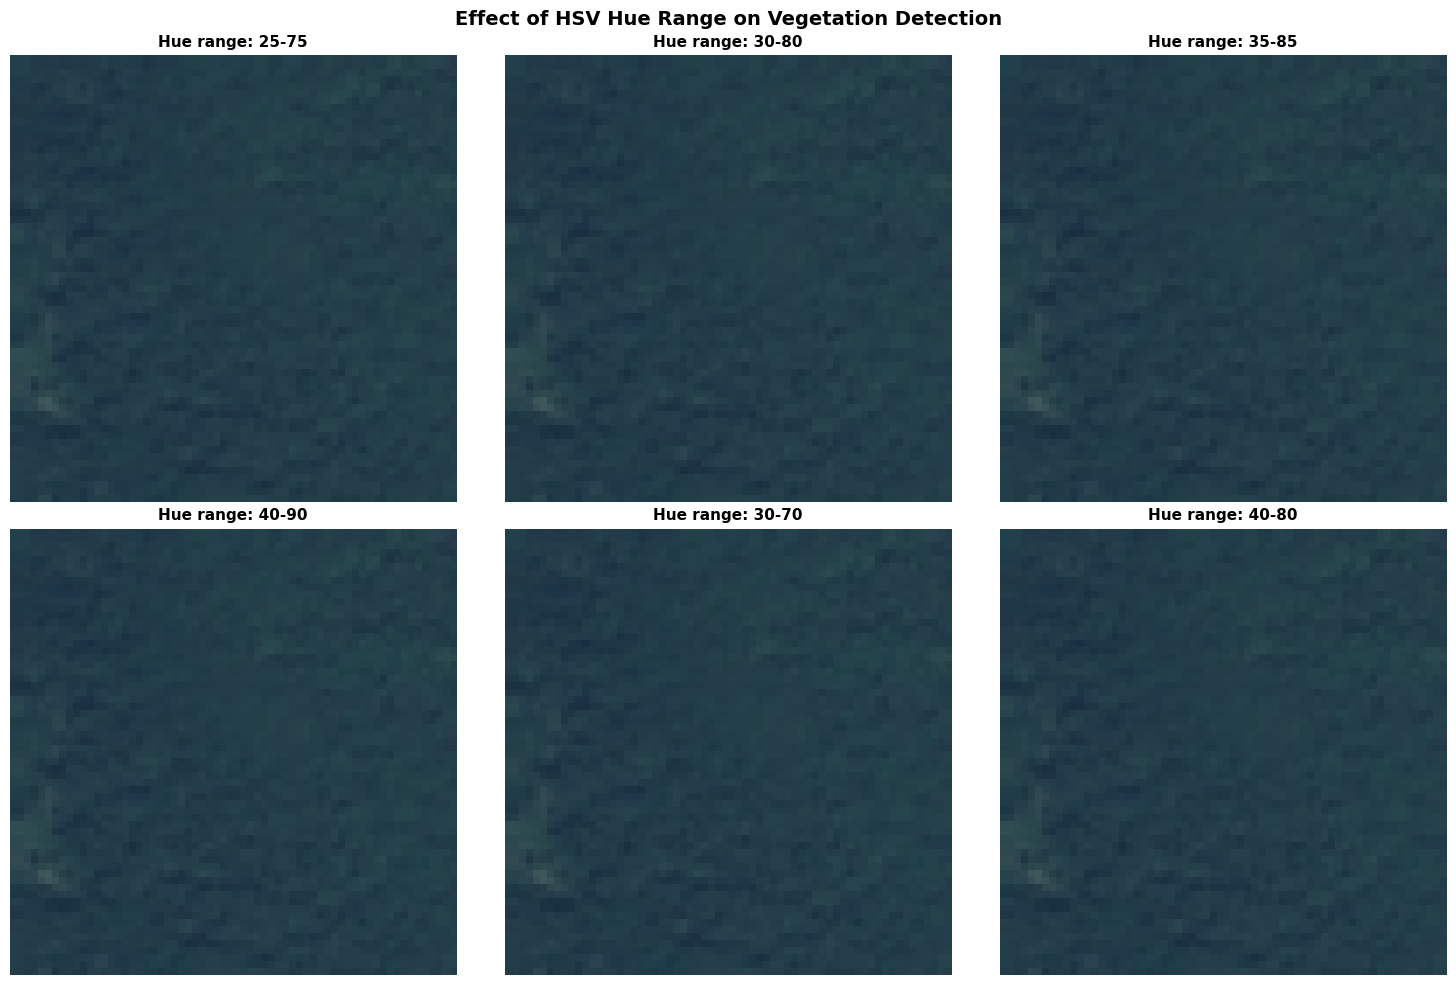

In [15]:
# Experiment with different HSV hue ranges
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Different green hue ranges (min, max)
hue_ranges = [
    (25, 75),
    (30, 80),
    (35, 85),
    (40, 90),
    (30, 70),
    (40, 80)
]

for idx, (hue_min, hue_max) in enumerate(hue_ranges):
    row = idx // 3
    col = idx % 3
    
    mask = detect_vegetation_hsv(test_img, hue_min=hue_min, hue_max=hue_max)
    overlay = apply_colored_overlay(test_img, mask)
    
    axes[row, col].imshow(overlay)
    axes[row, col].set_title(f'Hue range: {hue_min}-{hue_max}', fontsize=11, fontweight='bold')
    axes[row, col].axis('off')

plt.suptitle('Effect of HSV Hue Range on Vegetation Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Summary

In [16]:
print("\n" + "="*70)
print("VEGETATION DETECTION FILTER - SUMMARY")
print("="*70)

print("\nFilters Implemented:")
print("  1. ExG Filter: Excess Green Index (2G - R - B) >= threshold")
print("  2. HSV Filter: Green hue range (35-85°) + min saturation & value")
print("  3. Combined: ExG AND HSV (conservative) + morphological cleaning")

print("\nVisualization:")
print("  - Overlay color: Green (semi-transparent)")
print("  - Side-by-side: Original | Mask | Overlay")
print("  - ExG index heatmap (red-yellow-green)")

print("\nPerformance on test samples:")
for category in CATEGORIES:
    stats = results[category]
    print(f"  - {category.replace('_', ' ').title()}: {stats['mean']:.1f}% ± {stats['std']:.1f}%")

print("\nKey Insights:")
if results['green_area']['mean'] > 50:
    print("  ✓ Successfully detects vegetation in green area images (>50% coverage)")
else:
    print("  ⚠ Low detection in green areas - consider tuning thresholds")

non_vegetation_avg = np.mean([results[cat]['mean'] for cat in ['cloudy', 'desert', 'water']])
if non_vegetation_avg < 20:
    print("  ✓ Low false positives in non-vegetation images (<20% average)")
else:
    print("  ⚠ High false positives - consider stricter thresholds")

print("\nAdvantages of AND combination (vs OR):")
print("  - More conservative: reduces false positives")
print("  - Pixel must be green in BOTH color space AND greenness index")
print("  - Better discrimination against water/sky with blue-green tint")

print("\n" + "="*70)
print("✓ Vegetation detection filter completed")
print("  Next step: Water detection (03_filter_water.ipynb)")
print("="*70)


VEGETATION DETECTION FILTER - SUMMARY

Filters Implemented:
  1. ExG Filter: Excess Green Index (2G - R - B) >= threshold
  2. HSV Filter: Green hue range (35-85°) + min saturation & value
  3. Combined: ExG AND HSV (conservative) + morphological cleaning

Visualization:
  - Overlay color: Green (semi-transparent)
  - Side-by-side: Original | Mask | Overlay
  - ExG index heatmap (red-yellow-green)

Performance on test samples:
  - Cloudy: 2.3% ± 8.2%
  - Desert: 0.0% ± 0.0%
  - Green Area: 5.8% ± 17.4%
  - Water: 3.4% ± 14.9%

Key Insights:
  ⚠ Low detection in green areas - consider tuning thresholds
  ✓ Low false positives in non-vegetation images (<20% average)

Advantages of AND combination (vs OR):
  - More conservative: reduces false positives
  - Pixel must be green in BOTH color space AND greenness index
  - Better discrimination against water/sky with blue-green tint

✓ Vegetation detection filter completed
  Next step: Water detection (03_filter_water.ipynb)
